In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AIFFEL

Mounted at /content/drive
/content/drive/MyDrive/AIFFEL


In [2]:
! mkdir -p ./work/transformer_chatbot/data/
! wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
! mv ChatbotData.csv ./work/transformer_chatbot/data/
! pip install sentencepiece

--2025-11-04 02:31:11--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2025-11-04 02:31:12--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv’

ChatbotData.csv     100%[===================>] 868.99K  --.-KB/s    in 0.04s   

2025-11-04 02:31:12 (22.6 MB/s) - ‘ChatbotData.csv’ saved [889842/889842]



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import torch
print(torch.__version__)

2.8.0+cu126


# 트랜스포머 입력 이해하기

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

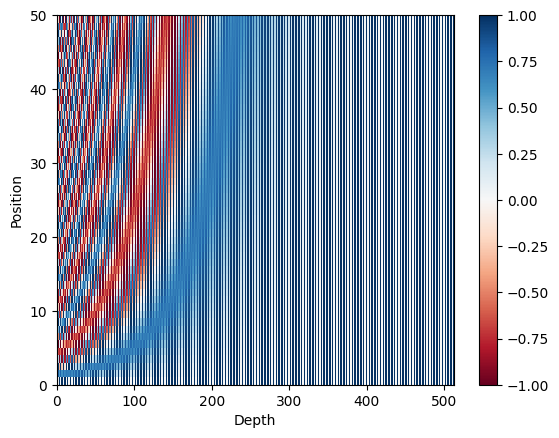

In [6]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# 어텐션 구현

## Scaled dot product attention

In [7]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

## Multi Head Attention

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


# Masking

## Padding Masking

In [9]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [10]:
x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


## Look-ahead masking

In [11]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [12]:
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [13]:
x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


# 인코더

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2

In [15]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

# 디코더

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [17]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

# 챗봇 데이터 확인하기

[Chatbot_data 출처](https://github.com/songys/Chatbot_data)

In [18]:
# 코넬 대사 데이터 폴더 경로
path_to_dataset = '/content/drive/MyDrive/AIFFEL/work/transformer_chatbot/data'

# 개별 파일 경로 설정
path_to_ko_chatbot = os.path.join(path_to_dataset, 'ChatbotData.csv')

print("path_to_dataset:", path_to_dataset)
print("path_to_ko_chatbot:", path_to_ko_chatbot)

path_to_dataset: /content/drive/MyDrive/AIFFEL/work/transformer_chatbot/data
path_to_ko_chatbot: /content/drive/MyDrive/AIFFEL/work/transformer_chatbot/data/ChatbotData.csv


In [19]:
raw_data = pd.read_csv(path_to_ko_chatbot)
raw_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [20]:
# 챗봇 트레이닝용 문답 페어 11,876개
# 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
raw_data.groupby('label').count()

,Q,A
label,,
0,5290,5290
1,3570,3570
2,2963,2963


In [21]:
# 0 : 일상 공감
label_0 = raw_data[raw_data['label'] == 0]
label_0.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [22]:
# 1 : 이별(부정)
label_1 = raw_data[raw_data['label'] == 1]
label_1.head()

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1


In [23]:
# 2 : 사랑(긍정)
label_2 = raw_data[raw_data['label'] == 2]
label_2.head()

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2


# 사용할 샘플 최대 개수 정의, 전처리 함수, 챗봇 데이터 가공 함수 정의

In [24]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [25]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 1. 양쪽 공백 제거
    sentence = sentence.strip()

    # 2. 특수문자 및 이모지 제거 (한글, 영어, 숫자, 기본 구두점만 허용)
    sentence = re.sub(r"[^가-힣0-9a-zA-Z.,!?~\s]", " ", sentence)

    # 3. 연속된 공백 하나로 축소
    sentence = re.sub(r"\s+", " ", sentence)

    # 4. 문장 부호 앞뒤로 공백 추가 (토큰 구분을 위함)
    sentence = re.sub(r"([?.!,~])", r" \1 ", sentence)
    sentence = re.sub(r'\s{2,}', ' ', sentence)

    return sentence.strip()

In [26]:
sample_sentence = "안녕하세요? Hello! I'm a student😊, nice to meet you! 1년 만났는데도 그 사람에 대해 잘 모르겠어."

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

안녕하세요 ? Hello ! I m a student , nice to meet you ! 1년 만났는데도 그 사람에 대해 잘 모르겠어 .


In [27]:
def read_ko_chatbot_data(
    path_to_csv,
    max_samples=50000,
    drop_duplicates=True,
    shuffle=True,
    seed=42,
    min_len=1,
    use_label=False
):
    """
    CSV 파일에서 Q/A 쌍을 읽고, 전처리한 뒤 (Q, A) 튜플 리스트를 반환합니다.
    CSV에는 반드시 'Q', 'A' 컬럼이 포함되어야 하며,
    'label' 컬럼이 있을 경우 use_label=True로 설정하면 함께 반환합니다.
    """

    # 1️⃣ CSV 로드 (인코딩 자동 시도)
    encodings = ["utf-8-sig", "utf-8", "cp949"]
    last_err = None
    for enc in encodings:
        try:
            df = pd.read_csv(path_to_csv, encoding=enc)
            break
        except Exception as e:
            last_err = e
            df = None
    if df is None:
        raise last_err

    # 2️⃣ 컬럼 확인
    if not {"Q", "A"}.issubset(df.columns):
        raise ValueError("CSV에는 반드시 'Q', 'A' 컬럼이 포함되어야 합니다.")

    # 3️⃣ 기본 정리
    df["Q"] = df["Q"].astype(str).str.strip()
    df["A"] = df["A"].astype(str).str.strip()

    # 4️⃣ 결측치 제거
    df = df.replace({"Q": {"": np.nan}, "A": {"": np.nan}}).dropna(subset=["Q", "A"])

    # 5️⃣ 중복 제거
    if drop_duplicates:
        df = df.drop_duplicates(subset=["Q", "A"])

    # 6️⃣ 전처리 적용
    df["Q"] = df["Q"].apply(preprocess_sentence)
    df["A"] = df["A"].apply(preprocess_sentence)

    # 7️⃣ 너무 짧은 문장 제거
    df = df[(df["Q"].str.len() >= min_len) & (df["A"].str.len() >= min_len)]

    # 8️⃣ 셔플
    if shuffle:
        df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    # 9️⃣ 최대 샘플 제한
    if max_samples is not None:
        df = df.iloc[:max_samples]

    # 🔟 label 컬럼 처리
    if use_label and "label" in df.columns:
        return list(df[["Q", "A", "label"]].itertuples(index=False, name=None))
    else:
        # label을 사용하지 않거나 컬럼이 없으면 제거
        return list(df[["Q", "A"]].itertuples(index=False, name=None))

In [28]:
no_label_data = raw_data.drop('label', axis=1)
no_label_data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [29]:
pairs = read_ko_chatbot_data(path_to_ko_chatbot, max_samples=MAX_SAMPLES)

print('전체 샘플 수 :', len(pairs))
print("첫 번째 페어 : ", pairs[0])

전체 샘플 수 : 11750
첫 번째 페어 :  ('사랑이란 뭘까 ?', '사랑에는 답이 없어요 .')


In [30]:
pairs_labels = read_ko_chatbot_data(path_to_ko_chatbot, max_samples=MAX_SAMPLES, use_label=True)

print('전체 샘플 수 :', len(pairs_labels))
print("첫 번째 페어 : ", pairs_labels[0])

전체 샘플 수 : 11750
첫 번째 페어 :  ('사랑이란 뭘까 ?', '사랑에는 답이 없어요 .', 1)


# 병렬 데이터 전처리하기

## Tokenizer 학습

pair로 묶은 데이터를 말뭉치로 전환

In [31]:
corpus_file = "/content/drive/MyDrive/AIFFEL/work/transformer_chatbot/data/clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [32]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="./work/transformer_chatbot/spm_ko_chatbot",
    vocab_size=8000,
    character_coverage=1.0,
    model_type="bpe",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)


In [33]:
sp = spm.SentencePieceProcessor()
sp.Load("./work/transformer_chatbot/spm_ko_chatbot.model")

True

In [34]:
# 예제 문장
sentence = "내가 싫어졌대! 나 이제 어떻게 살아야 해?"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 내가 싫어졌대 ! 나 이제 어떻게 살아야 해 ?
Tokenized: ['▁내가', '▁싫어', '졌', '대', '▁!', '▁나', '▁이제', '▁어떻게', '▁살아야', '▁해', '▁?']
Encoded: [165, 401, 6954, 6851, 112, 15, 145, 182, 3408, 31, 11]
Decoded: 내가 싫어졌대 ! 나 이제 어떻게 살아야 해 ?


## Dataset 구현

In [35]:
class KoChatbotDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

# 모델 정의 및 학습

In [36]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

## 모델 생성

In [137]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2     # 인코더/디코더 층 수
D_MODEL = 128      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=128, out_features=128, bias=True)
          (key_dense): Linear(in_features=128, out_features=128, bias=True)
          (value_dense): Linear(in_features=128, out_features=128, bias=True)
          (out_dense): Linear(in_features=128, out_features=128, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((128,), eps=1e-06, elementwise_aff

## 손실 함수

In [138]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

## 커스텀 된 학습률

In [139]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

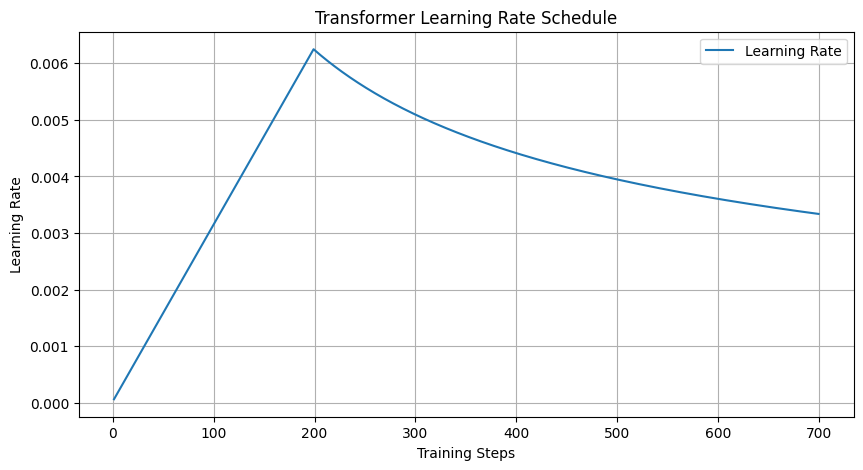

In [140]:
# 하이퍼파라미터 설정
d_model = 128
warmup_steps = 200
total_steps = 700  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


## 모델 컴파일

In [141]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=200))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [142]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

## 훈련함수 정의하기

In [143]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [144]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if epoch % 10 == 9:
                if step % 100 == 0:
                    print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        if epoch % 10 == 9:
            print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

# 챗봇 테스트 함수 만들기

In [145]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [146]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

# Label 데이터 없이 모델 학습

In [147]:
pairs = read_ko_chatbot_data(path_to_ko_chatbot, max_samples=MAX_SAMPLES)

print('전체 샘플 수 :', len(pairs))
print("첫 번째 페어 : ", pairs[0])

전체 샘플 수 : 11750
첫 번째 페어 :  ('사랑이란 뭘까 ?', '사랑에는 답이 없어요 .')


In [148]:
dataset = KoChatbotDataset(pairs, sp, max_length=10)

In [149]:
for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([10])
tensor([   1,  347, 7176,  954,   11,    2,    0,    0,    0,    0])
사랑이란 뭘까 ?
tensor([   1, 3879, 3246,  281,    4,    2,    0,    0,    0])
사랑에는 답이 없어요 .
tensor([3879, 3246,  281,    4,    2,    0,    0,    0,    0])
사랑에는 답이 없어요 .


## DataLoader 구성

In [150]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [151]:
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 10])
torch.Size([32, 9])
torch.Size([32, 9])


In [156]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=500,  # 원하는 에폭 수
    device=device
)

[Epoch 10, Step 0] Loss: 5.8427, Acc: 0.2958
[Epoch 10, Step 100] Loss: 5.6799, Acc: 0.3316
[Epoch 10, Step 200] Loss: 5.5553, Acc: 0.3277
Epoch 10 Completed - Avg Loss: 5.6667, Avg Acc: 0.3244
[Epoch 20, Step 0] Loss: 5.7279, Acc: 0.3316
[Epoch 20, Step 100] Loss: 5.7470, Acc: 0.3163
[Epoch 20, Step 200] Loss: 5.5250, Acc: 0.3247
Epoch 20 Completed - Avg Loss: 5.6367, Avg Acc: 0.3242
[Epoch 30, Step 0] Loss: 5.5589, Acc: 0.3299
[Epoch 30, Step 100] Loss: 5.6569, Acc: 0.3264
[Epoch 30, Step 200] Loss: 5.4724, Acc: 0.3282
Epoch 30 Completed - Avg Loss: 5.6103, Avg Acc: 0.3243
[Epoch 40, Step 0] Loss: 5.7096, Acc: 0.3279
[Epoch 40, Step 100] Loss: 5.5561, Acc: 0.3226
[Epoch 40, Step 200] Loss: 5.5630, Acc: 0.3144
Epoch 40 Completed - Avg Loss: 5.5860, Avg Acc: 0.3244
[Epoch 50, Step 0] Loss: 5.7877, Acc: 0.3153
[Epoch 50, Step 100] Loss: 5.5918, Acc: 0.3196
[Epoch 50, Step 200] Loss: 5.2676, Acc: 0.3631
Epoch 50 Completed - Avg Loss: 5.5648, Avg Acc: 0.3252
[Epoch 60, Step 0] Loss: 5.556

In [157]:
print("d_model : 128, warming states : 200")

d_model : 128, warming states : 200


In [158]:
sentence = '얼마 전에 헤어졌어요.'
sentence_generation(model, sentence, sp, device)

입력 : 얼마 전에 헤어졌어요.
출력 : 잘 수 있을 거예요 .


'잘 수 있을 거예요 .'

In [159]:
sentence = "요즘 너무 행복해요!"
sentence_generation(model, sentence, sp, device)

입력 : 요즘 너무 행복해요!
출력 : 좋은 거예요 .


'좋은 거예요 .'